In [215]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [216]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [217]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [218]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///resources/hawaii.sqlite")

In [219]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [220]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [221]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement
joined = Base.classes


In [222]:
# Create our session (link) from Python to the DB
session = Session(engine)

conn = engine.connect()
mes = pd.read_sql("select * from measurement", conn)
sta = pd.read_sql("select * from station", conn)
join = pd.read_sql('select station.station, name, latitude,\
                longitude, elevation, date, prcp,\
                tobs from station join measurement\
                on measurement.station = station.station', conn)
mes.head(5000)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
4995,4996,USC00513117,2016-05-20,0.15,75.0
4996,4997,USC00513117,2016-05-21,0.08,75.0
4997,4998,USC00513117,2016-05-22,0.00,75.0
4998,4999,USC00513117,2016-05-23,0.00,75.0


# Exploratory Precipitation Analysis

In [223]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [224]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= '2016-08-23').\
                order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results[:], columns=['date', 'prcp']).fillna(0)
df.set_index('date', inplace=True, )
df.head(10)

# Sort the dataframe by date
df.sort_values(by='date')



,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.00
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


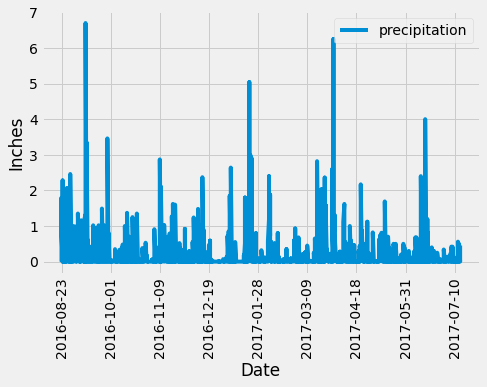

In [298]:
# # Use Pandas Plotting with Matplotlib to plot the data

x = df.index
y = df['prcp']
labellist = df.index[::250]
tickvalues = np.arange(0,len(df),step=45)
plt.figure(figsize = (7,4.5))
plt.xticks(ticks = tickvalues,labels = labellist, rotation = 'vertical')
plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'], loc='best')
plt.show()

In [226]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rtmin = df.min()
rtmax = df.max()
rtavg = df.mean()
rtmed = df.median()
# dataframe to hold all of the stats above
rt_sum = pd.DataFrame({
                    "Min": rtmin,
                    "Max": rtmax,
                    "Mean": rtavg,
                    "Median": rtmed
})
rt_sum

,Min,Max,Mean,Median
prcp,0.0,6.7,0.160664,0.01


# Exploratory Station Analysis

In [227]:
# Design a query to calculate the total number stations in the dataset
session.query(func.distinct(Measurement.station)).count()

9

In [300]:
session.query(Measurement.station).distinct().all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [228]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(func.count('*'), Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count('*').desc()).all()

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [291]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min = session.query(func.min(Measurement.tobs),Measurement.station).filter(Measurement.station == 'USC00519281').all()
max = session.query(func.max(Measurement.tobs),Measurement.station).filter(Measurement.station == 'USC00519281').all()
avg = session.query(func.avg(Measurement.tobs),Measurement.station).filter(Measurement.station == 'USC00519281').all()

print(f'min = {min}\n'\
    f'max = {max}\n'\
    f'avg = {avg}')

min = [(54.0, 'USC00519281')]
max = [(85.0, 'USC00519281')]
avg = [(71.66378066378067, 'USC00519281')]


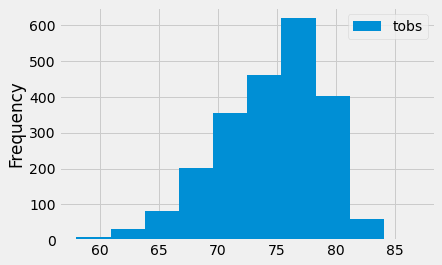

In [296]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
ma_12 = session.query(Measurement.tobs, Measurement.date).filter(Measurement.date >= '2016-08-23').all()
ma_12_df = pd.DataFrame(ma_12[:], columns=['tobs', 'date']).fillna(0)
ma_12_df.set_index('date', inplace=True, )
ma_12_df.head(10)
ma_12_df.plot(kind='hist')
plt.xlabel('Temperature °F')
plt.show()

# Close session

In [297]:
# Close Session
session.close()